In [58]:
import os, glob, sys
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow, imsave
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from ShowColors import *
from ImportUtil import *
%env CITYSCAPES_DATASET = /home/rvygon/data/

%load_ext autoreload
%autoreload 2

env: CITYSCAPES_DATASET=/home/rvygon/data/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
#run this cell once
#%run  cityscapesscripts/preparation/createTrainIdInstanceImgs
#%run  cityscapesscripts/preparation/createTrainIdInstanceImgs

In [60]:
x_val, y_val,files = importBatch(50,50,0,'val',scale = 4)
from keras.utils import to_categorical
y_val[y_val==255]=19
y_val = to_categorical(y_val)

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess_pic(X, y):
    y[y==255]=19
    y=to_categorical(y)
    return X, y

def keras_generator(batch_size,scale):
    while True:
        batch_nums = np.random.randint(low=1000, high=2000, size=batch_size)
        batch_input = []
        batch_output = []
        
        for index in batch_nums:
            input_labels, input_images = getData(1, index,type='train')
            input_image = input_images[0]
            input_label = input_labels[0]           
            
            X_img = imread(input_image)
            if (scale != 0):
                X_new = np.zeros((int(X_img.shape[0] / scale), int(X_img.shape[1] / scale),3))
                k = 0
                for x in X_img[::scale]:
                    X_new[k]=x[::scale]
                    k+=1
                X_img = X_new
            y_img = imread(input_label)
            if (scale != 0):
                y_new = np.zeros((int(y_img.shape[0] / scale), int(y_img.shape[1] / scale)))
                k = 0
                for y in y_img[::scale]:
                    y_new[k] = y[::scale]
                    k += 1
                y_img = y_new
            
            X_img, y_img = preprocess_pic(X_img, y_img)
            
            batch_input.append(X_img)
            batch_output.append(y_img)
            
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)        
        yield batch_x, batch_y
        

In [62]:
#UNET https://github.com/zhixuhao/unet/blob/master/model.py
def unet(pretrained_weights = None,input_size = (256,512,3)):
    inputs = Input(input_size)
  
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)    
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))#drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(20, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [16]:
model =  load_model('unet_RV.hdf5')
# model = unet()
generator = keras_generator(1,4)
model_checkpoint = ModelCheckpoint('unet_RV.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(generator,steps_per_epoch=1500,epochs=8,callbacks=[model_checkpoint], validation_data=(x_val,y_val),validation_steps=20)

Epoch 1/8
  37/1500 [..............................] - ETA: 3:53 - loss: 1.8717 - acc: 0.3324

KeyboardInterrupt: 

In [49]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image

resnet_model = ResNet50(weights='imagenet', input_shape=(256, 512, 3), include_top=False)

/opt/conda/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [50]:
resnet_out = resnet_model.output
resnet_out

<tf.Tensor 'activation_245/Relu:0' shape=(?, 8, 16, 2048) dtype=float32>

In [51]:
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 518, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [53]:
conv1 = resnet_model.get_layer('activation_197').output #shape 128 256 64
conv2 = resnet_model.get_layer('activation_206').output #shape 64 128 64
conv3 = resnet_model.get_layer('activation_217').output #shape 32 64 128
conv4 = resnet_model.get_layer('activation_233').output #shape 16 32 256
conv5 = resnet_model.get_layer('activation_245').output #shape 8 16 512

In [63]:
def resnet_unet(pretrained_weights = None,input_size = (256,512,3)):
    conc_1 = Concatenate(axis=3)([UpSampling2D(size=(2, 2), interpolation='bilinear')(conv5), conv4])
    conv_conc_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_1)
    conv_conc_1 = BatchNormalization()(conv_conc_1)
    conv_conc_1 = LeakyReLU()(conv_conc_1)
    conv_conc_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_1)
    conv_conc_1 = BatchNormalization()(conv_conc_1)
    conv_conc_1 = LeakyReLU()(conv_conc_1)
    
    conc_2 = Concatenate(axis=3)([UpSampling2D(size=(2, 2), interpolation='bilinear')(conv4), conv3])
    conv_conc_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_2)
    conv_conc_2 = BatchNormalization()(conv_conc_2)
    conv_conc_2 = LeakyReLU()(conv_conc_2)
    conv_conc_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_2)
    conv_conc_2 = BatchNormalization()(conv_conc_2)
    conv_conc_2 = LeakyReLU()(conv_conc_2)
    
    conc_3 = Concatenate(axis=3)([UpSampling2D(size=(2, 2), interpolation='bilinear')(conv3), conv2])
    conv_conc_3 = Conv2D(64, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_3)
    conv_conc_3 = BatchNormalization()(conv_conc_3)
    conv_conc_3 = LeakyReLU()(conv_conc_3)
    conv_conc_3 = Conv2D(64, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_3)
    conv_conc_3 = BatchNormalization()(conv_conc_3)
    conv_conc_3 = LeakyReLU()(conv_conc_3)
    
    conc_4 = Concatenate(axis=3)([UpSampling2D(size=(2, 2), interpolation='bilinear')(conv2), conv1])
    conv_conc_4 = Conv2D(32, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_4)
    conv_conc_4 = BatchNormalization()(conv_conc_4)
    conv_conc_4 = LeakyReLU()(conv_conc_4)
    conv_conc_4 = Conv2D(32, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_4)
    conv_conc_4 = BatchNormalization()(conv_conc_4)
    conv_conc_4 = LeakyReLU()(conv_conc_4)
    
    conc_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_conc_4)
    conv_conc_5 = Conv2D(16, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_5)
    conv_conc_5 = BatchNormalization()(conv_conc_5)
    conv_conc_5 = LeakyReLU()(conv_conc_5)
    conv_conc_5 = Conv2D(16, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_5)
    conv_conc_5 = BatchNormalization()(conv_conc_5)
    conv_conc_5 = LeakyReLU()(conv_conc_5)
    
    last = Conv2D(20, 1, activation = 'sigmoid')(conv_conc_5)
    
    model = Model(input=resnet_model.input, output=last)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [68]:
resnet_generator = keras_generator(1,  4)

In [71]:
# resnet_unet_model = resnet_unet()
resnet_unet_model = load_model('resnet_unet.hdf5')

In [ ]:
resnet_checkpoint = ModelCheckpoint('resnet_unet.hdf5', monitor='loss', verbose=1, save_best_only=True)
resnet_unet_model.fit_generator(resnet_generator, steps_per_epoch=1500, epochs=100, callbacks=[resnet_checkpoint], validation_data=(x_val, y_val), validation_steps=20)

Epoch 1/100
 754/1500 [==============>...............] - ETA: 2:05 - loss: 0.6012 - acc: 0.8230

In [17]:
# new_model = load_model('unet_RV.hdf5')
#new_model.summary()
# model = new_model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 512, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 512, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 256, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [18]:
results = model.predict(x_val,verbose=1)
print(results[1].shape)
results=results.astype(int)
#res_image=np.argmax(results[0], axis=2)
colorImage(x_val[1], results[1], 'classes.txt')

50/50 [==============================] - 5s 91ms/step
(256, 512, 20)


FileNotFoundError: [Errno 2] No such file or directory: 'classes.txt'

In [10]:
x_pred=model.predict(x_val,verbose=1)
x_pred = np.argmax(x_pred,axis=3)
x_pred.shape

50/50 [==============================] - 1s 26ms/step


(50, 256, 512)

In [11]:
x_up = UpscaleImg(x_pred[0], 4,False)
x_up.shape

(1024, 2048)

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


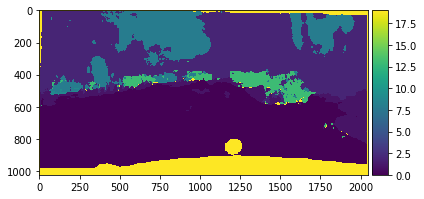

In [12]:
imshow(x_up)

In [13]:
x_val, y_val, filenames = importBatch(500,0,0,'val',4)
x_pred = model.predict(x_val,verbose=1)

500/500 [==============================] - 12s 23ms/step


In [15]:
new_x=np.argmax(x_pred,axis=3)
new_x.shape
new_new_x = np.zeros((new_x.shape[0],new_x.shape[1]*4,new_x.shape[2]*4))

In [ ]:
for i in range(x_pred.shape[0]):
    new_new_x[i]=UpscaleImg(new_x[i],4,0)

In [ ]:
%%capture cap --no-stderr

new_new_x = new_new_x.astype(int)
def eval_model(model):    
        cityscapesPath = os.environ['CITYSCAPES_DATASET']        
        for i in range(len(filenames)):
            impath = os.path.join(cityscapesPath,'results', filenames[i].split('/')[7]+'.png')           
            imsave(impath, new_new_x[i])
        %run cityscapesscripts/evaluation/evalPixelLevelSemanticLabeling
eval_model(new_model)
with open('output.txt', 'w') as f:
    f.write(cap.stdout)



    

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000000_000294.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000000_000576.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000000_001016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000000_001236.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000000_001751.png is a low contrast image
  war

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000000_017476.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000000_018797.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000000_019607.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000000_020215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000000_020321.png is a low contrast image
  war

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_012038.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_012519.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_012699.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_012738.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_012870.png is a low contrast image
  war

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_029086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_029236.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_029600.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_030067.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_030310.png is a low contrast image
  war

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_046779.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_047178.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_047552.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_048196.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_048355.png is a low contrast image
  war

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_059789.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_060135.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_060422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_060545.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_060906.png is a low contrast image
  war

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_073243.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_073464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_073911.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_075296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/frankfurt_000001_075984.png is a low contrast image
  war

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/lindau_000022_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/lindau_000023_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/lindau_000024_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/lindau_000025_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/lindau_000026_000019.png is a low contrast image
  warn('%s is a low 

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000005_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000006_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000007_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000008_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000009_000019.png is a low contrast image
  warn('%s is a

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000047_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000048_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000049_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000050_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000051_000019.png is a low contrast image
  warn('%s is a

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000087_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000088_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000089_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000090_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000091_000019.png is a low contrast image
  warn('%s is a

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000127_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000128_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000129_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000130_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000131_000019.png is a low contrast image
  warn('%s is a

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000167_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000168_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000169_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000170_000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rvygon/data/results/munster_000171_000019.png is a low contrast image
  warn('%s is a

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


IndexError: index 15 is out of bounds for axis 0 with size 10

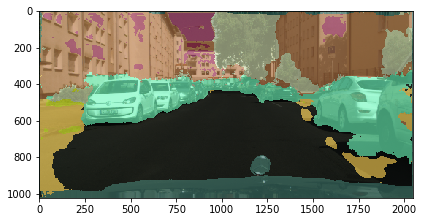

In [22]:
x_val.shape,new_new_x.shape

for i in [1,15,20,42]:
    colorImage(UpscaleImg(x_val[i],4,1), new_new_x[i], 'classes.txt')

In [23]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13621833291701252735, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11287530701
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5045510980413374096
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 74f6:00:00.0, compute capability: 3.7"]